In [ ]:
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [2]:
import pandas as pd
import networkx as nx
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
dataset_path = "preprocessed_transactions.csv"
df = pd.read_csv(dataset_path)
df.head()

,User,Card,Year,Month,Day,Amount,Merchant Name,MCC,Errors?,Is Fraud?,Hour,Minute
0,0,0,2015,1,26,3109,4241336128694185533,4814,NaN,False,16,38
1,0,0,2015,3,22,4587,-4241409341442030551,7349,NaN,False,20,49
2,0,0,2015,3,26,6976,-9092677072201095172,4900,NaN,False,20,46
3,0,0,2015,4,13,14503,-9092677072201095172,4900,NaN,False,13,25
4,0,0,2015,5,1,2163,4241336128694185533,4814,NaN,False,16,40


Missing values in numerical columns are imputed with their mean. Categorical columns are encoded into numeric values using `LabelEncoder`, while numerical columns are standardized with `StandardScaler` to ensure consistent scaling.

In [4]:
df['Is Fraud?'] = df['Is Fraud?'].astype(int)

df.fillna(df.mean(numeric_only=True), inplace=True)

categorical_columns = ['Merchant Name', 'MCC']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

numerical_columns = ['Year', 'Month', 'Day', 'Amount', 'Hour', 'Minute']
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

Undersampling for balancing the dataset by reducing the majority class to match the size of the minority class. In this case, rows labeled as non-fraud are randomly sampled to match the number of fraud cases, ensuring an even class distribution for training.

In [5]:
fraud = df[df['Is Fraud?'] == 1]
non_fraud = df[df['Is Fraud?'] == 0].sample(len(fraud), random_state=42)
df_balanced = pd.concat([fraud, non_fraud])

Construct a **graph** where **nodes** represent rows in the dataset (transactions), each enriched with features derived from the data.

**Edges** are added between nodes that share common values in specified columns (e.g., `'User'`, `'Card'`), capturing relationships between transactions based on shared user or card. These edges are then filtered to ensure they only connect valid nodes corresponding to dataset rows.

Finally, the **graph structure** (edges), **node features**, and **labels** are prepared as tensors for integration with **PyTorch Geometric**, enabling graph-based machine learning.


In [7]:
G = nx.Graph()

# Add nodes with features
for index, row in df_balanced.iterrows():
    G.add_node(index, **row.to_dict())

# Add edges based on shared features
shared_features = ['User', 'Card']
for feature in shared_features:
    feature_dict = {}
    for index, value in df_balanced[feature].items():
        if value not in feature_dict:
            feature_dict[value] = []
        feature_dict[value].append(index)
    for nodes in feature_dict.values():
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                G.add_edge(nodes[i], nodes[j])

# Restrict edges to valid node indices
valid_node_indices = set(range(len(df_balanced)))
filtered_edges = [(u, v) for u, v in G.edges if u in valid_node_indices and v in valid_node_indices]

edge_index = torch.tensor(filtered_edges, dtype=torch.long).t().contiguous()

node_features = torch.tensor(df_balanced[numerical_columns + categorical_columns].values, dtype=torch.float)

labels = torch.tensor(df_balanced['Is Fraud?'].values, dtype=torch.long)

data = Data(x=node_features, edge_index=edge_index, y=labels)

The data is split into training and validation sets using `train_test_split`.  The `train_mask` and `test_mask` are **boolean tensors** that indicate which indices belong to the training and validation sets, respectively.

In [8]:
train_idx, test_idx = train_test_split(range(len(labels)), test_size=0.2, stratify=labels, random_state=42)
train_mask = torch.tensor([i in train_idx for i in range(len(labels))], dtype=torch.bool)
test_mask = torch.tensor([i in test_idx for i in range(len(labels))], dtype=torch.bool)

Architecture implementing a **GraphSAGE** (Graph Sample and Aggregate) model with two convolutional layers along with activation functions `ELU` and `log_softmax`. The first layer transforms the input features into a hidden representation, while the second outputs the final class logits.

In [9]:
class GraphSAGENet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGENet, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GraphSAGENet(in_channels=node_features.size(1), hidden_channels=16, out_channels=2)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = torch.nn.NLLLoss()

In [10]:
for epoch in range(2000):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        model.eval()
        pred = out[test_mask].argmax(dim=1)
        acc = (pred == data.y[test_mask]).sum().item() / test_mask.sum().item()
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Test Accuracy: {acc:.4f}")


Epoch 0, Loss: 5.0316, Test Accuracy: 0.4987
Epoch 50, Loss: 0.7827, Test Accuracy: 0.5030
Epoch 100, Loss: 0.6752, Test Accuracy: 0.5709
Epoch 150, Loss: 0.6593, Test Accuracy: 0.6393
Epoch 200, Loss: 0.6462, Test Accuracy: 0.6953
Epoch 250, Loss: 0.6350, Test Accuracy: 0.7009
Epoch 300, Loss: 0.6244, Test Accuracy: 0.7094
Epoch 350, Loss: 0.6093, Test Accuracy: 0.7201
Epoch 400, Loss: 0.5965, Test Accuracy: 0.7265
Epoch 450, Loss: 0.5815, Test Accuracy: 0.7269
Epoch 500, Loss: 0.5679, Test Accuracy: 0.7380
Epoch 550, Loss: 0.5562, Test Accuracy: 0.7462
Epoch 600, Loss: 0.5459, Test Accuracy: 0.7500
Epoch 650, Loss: 0.5363, Test Accuracy: 0.7547
Epoch 700, Loss: 0.5258, Test Accuracy: 0.7641
Epoch 750, Loss: 0.5170, Test Accuracy: 0.7726
Epoch 800, Loss: 0.5091, Test Accuracy: 0.7748
Epoch 850, Loss: 0.5018, Test Accuracy: 0.7821
Epoch 900, Loss: 0.4947, Test Accuracy: 0.7880
Epoch 950, Loss: 0.4883, Test Accuracy: 0.7919
Epoch 1000, Loss: 0.4823, Test Accuracy: 0.7970
Epoch 1050, Los

Precision: 0.8492
Recall: 0.8470


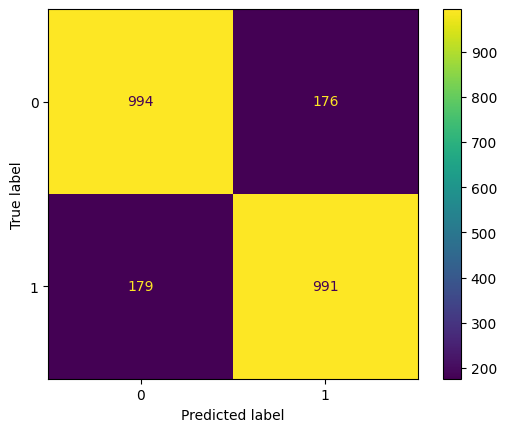

In [11]:
model.eval()
pred = out[test_mask].argmax(dim=1).cpu().numpy()
true_labels = data.y[test_mask].cpu().numpy()

precision = precision_score(true_labels, pred, average='binary')
recall = recall_score(true_labels, pred, average='binary')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

ConfusionMatrixDisplay.from_predictions(true_labels, pred)
plt.show()